In [1]:
import numpy as np 
 
import pandas as pd 
import os
import matplotlib.pyplot as plt 
%pip install seaborn
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Layer, Flatten
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

Note: you may need to restart the kernel to use updated packages.


# Grad-CAM Implementation
* Understand which part of your images play a role in the final activation of a class
* Project the important spatial features of your input images and analyse what can be changed to improve the classifier's performance

## Classes
- The name of the classes used in the dataset are the scientific names of the animal species

| Scientific Name | Regular Name |
| --- | --- |
| cane | dog |
| cavallo | horse |
| elefante | elephant |
| farfalla | butterfly |
| gallina | chicken |
| gatto | cat |
| mucca | cow |
| pecora | sheep |
| scoiattolo | squirrel |
| ragno | spider |

## Data Generator

In [4]:
batch_size = 2
img_size = 512
data_path = 'D:/Workshop/7_Flora_mask/data/data/'
datagen = ImageDataGenerator(rescale=1/255.,
                             rotation_range=20,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode='nearest',
                             validation_split=0.15)

train_generator = datagen.flow_from_directory(data_path,  
                                                target_size=(img_size, img_size), 
                                                batch_size=batch_size,
                                                shuffle=True,
                                                class_mode='categorical',
                                                subset='training')  

validation_generator = datagen.flow_from_directory(data_path,
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch_size,
                                                    shuffle=False,
                                                    class_mode='categorical',
                                                    subset='validation')

Found 90 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


## ConvNet Model (effiecentNet_V2)
* Finetune the entire network
* Keep the learning rate as small as possible because the new trained weights should be close the weights previously learnt to identify features of this use case

### Model Definition and Hyperparameter Settings

In [5]:

base_model= efficientnet_v2.EfficientNetV2M(
    include_top=False, input_shape=(img_size,img_size,3), classes=10
)

last = base_model.layers[-2].output
x = GlobalAveragePooling2D()(last)
x = Dense(512,'relu')(x)
x = Dense(10, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=x)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model.summary()

KeyboardInterrupt: 

### Model Checkpoints
- Reduce the learning rate if the validation loss does not decrease after 3 successive epochs
- Stop the training if the validation loss does not decrease after 5 successive epochs
- Save the best model if it has a better validation loss than before

In [5]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

### Model Training

In [6]:
history = model.fit(train_generator,
                    epochs=15,
                    validation_data=validation_generator,
                    callbacks=[checkpoint,earlystopping,learning_rate_reduction])

2022-06-25 06:29:28.259228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-06-25 06:29:30.443722: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


696/696 [==============================] - 481s 674ms/step - loss: 0.8752 - accuracy: 0.7070 - val_loss: 0.4919 - val_accuracy: 0.8414

Epoch 00001: val_loss improved from inf to 0.49190, saving model to model.h5
Epoch 2/15
696/696 [==============================] - 374s 537ms/step - loss: 0.3918 - accuracy: 0.8707 - val_loss: 0.3931 - val_accuracy: 0.8738

Epoch 00002: val_loss improved from 0.49190 to 0.39309, saving model to model.h5
Epoch 3/15
696/696 [==============================] - 372s 535ms/step - loss: 0.3022 - accuracy: 0.9033 - val_loss: 0.2962 - val_accuracy: 0.9041

Epoch 00003: val_loss improved from 0.39309 to 0.29617, saving model to model.h5
Epoch 4/15
696/696 [==============================] - 374s 537ms/step - loss: 0.2428 - accuracy: 0.9226 - val_loss: 0.2261 - val_accuracy: 0.9273

Epoch 00004: val_loss improved from 0.29617 to 0.22609, saving model to model.h5
Epoch 5/15
696/696 [==============================] - 374s 538ms/step - loss: 0.2195 - accuracy: 0.9301

### Learning Curves

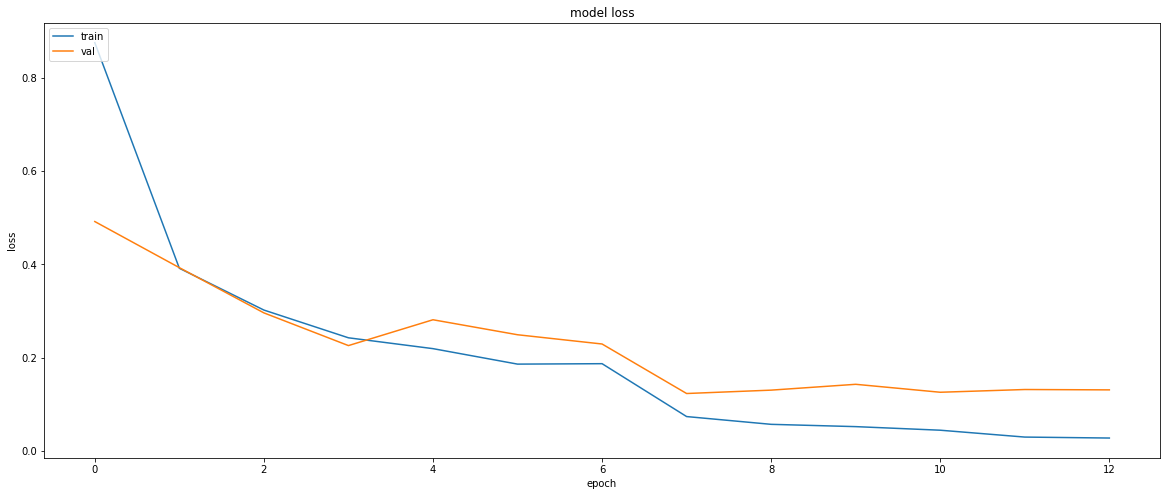

In [7]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

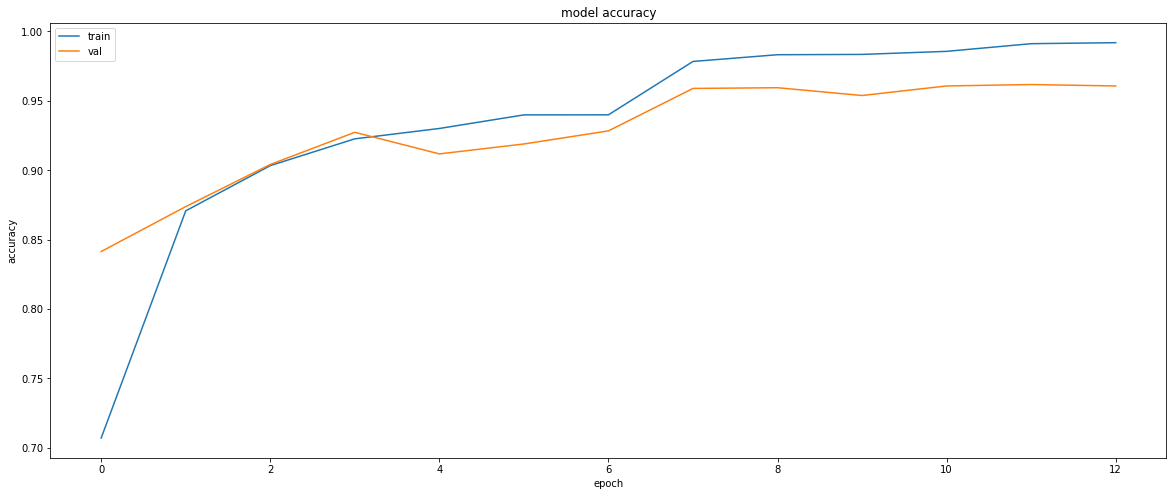

In [8]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Model Evalutation

In [9]:

from sklearn.metrics import classification_report

#Load our pre-trained model

In [6]:
model_path = "../weights.48-0.15.hdf5"
model = load_model(model_path)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 512, 512, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 512, 512, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                            

In [7]:
y_val = validation_generator.classes
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred,axis=1)

5/5 [==============================] - 19s 308ms/step


In [10]:
print(classification_report(y_val,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       0.00      0.00      0.00         1
           4       0.50      1.00      0.67         1
           5       1.00      1.00      1.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         1
           8       1.00      1.00      1.00         1
           9       1.00      1.00      1.00         1

    accuracy                           0.90        10
   macro avg       0.85      0.90      0.87        10
weighted avg       0.85      0.90      0.87        10



c:\Users\salim\anaconda3\envs\flora_mask\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\salim\anaconda3\envs\flora_mask\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\salim\anaconda3\envs\flora_mask\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [11]:
class_indices = validation_generator.class_indices
indices = {v:k for k,v in class_indices.items()}

In [12]:
filenames = validation_generator.filenames
print(filenames)

['01_Acer pseudoplatanus\\Acer pseudoplatanus0000001.jpg', '02_Aesculus hippocastanum\\Aesculus hippocastanum0000001.jpg', '03_Betula pendula\\Betula pendula0000001.jpg', '04_Carpinus betulus\\Carpinus betulus0000001.jpg', '05_Fagus sylvatica\\Fagus sylvatica0000001.jpg', '06_Fraxinus excelsior\\Fraxinus excelsior0000001.jpg', '07_Prunus avium\\Prunus avium0000001.jpg', '08_Quercus petraea\\Quercus petraea0000001.jpg', '09_Sorbus aucuparia\\Sorbus aucuparia0000001.jpg', '10_Tilia platyphyllos\\Tilia platyphyllos0000001.jpg']


In [13]:
# Assuming you have the list of filenames from the validation generator
filenames = validation_generator.filenames

# Replace backward slashes with forward slashes
filenames = [filename.replace('\\', '/') for filename in filenames]

# Now, converted_filenames contains the file paths with forward slashes
print(filenames)

['01_Acer pseudoplatanus/Acer pseudoplatanus0000001.jpg', '02_Aesculus hippocastanum/Aesculus hippocastanum0000001.jpg', '03_Betula pendula/Betula pendula0000001.jpg', '04_Carpinus betulus/Carpinus betulus0000001.jpg', '05_Fagus sylvatica/Fagus sylvatica0000001.jpg', '06_Fraxinus excelsior/Fraxinus excelsior0000001.jpg', '07_Prunus avium/Prunus avium0000001.jpg', '08_Quercus petraea/Quercus petraea0000001.jpg', '09_Sorbus aucuparia/Sorbus aucuparia0000001.jpg', '10_Tilia platyphyllos/Tilia platyphyllos0000001.jpg']


In [14]:
val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

,filename,actual,predicted,Same
0,01_Acer pseudoplatanus/Acer pseudoplatanus0000...,01_Acer pseudoplatanus,01_Acer pseudoplatanus,True
1,02_Aesculus hippocastanum/Aesculus hippocastan...,02_Aesculus hippocastanum,02_Aesculus hippocastanum,True
2,03_Betula pendula/Betula pendula0000001.jpg,03_Betula pendula,03_Betula pendula,True
3,04_Carpinus betulus/Carpinus betulus0000001.jpg,04_Carpinus betulus,05_Fagus sylvatica,False
4,05_Fagus sylvatica/Fagus sylvatica0000001.jpg,05_Fagus sylvatica,05_Fagus sylvatica,True
5,06_Fraxinus excelsior/Fraxinus excelsior000000...,06_Fraxinus excelsior,06_Fraxinus excelsior,True
6,07_Prunus avium/Prunus avium0000001.jpg,07_Prunus avium,07_Prunus avium,True
7,08_Quercus petraea/Quercus petraea0000001.jpg,08_Quercus petraea,08_Quercus petraea,True
8,09_Sorbus aucuparia/Sorbus aucuparia0000001.jpg,09_Sorbus aucuparia,09_Sorbus aucuparia,True
9,10_Tilia platyphyllos/Tilia platyphyllos000000...,10_Tilia platyphyllos,10_Tilia platyphyllos,True


In [15]:
val_df = val_df.sample(frac=1).reset_index(drop=True)

## Grad-CAM

"Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say 'dog' in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept." **- Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization** (Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra)

- Derivative of the class with the highest probability returned by the softmax layer is taken with respect to the final convolutional layer to produce a heat map which highlights the important regions in the image that activated the class.
- For full mathematical details please check out this paper: https://arxiv.org/abs/1610.02391

### Image Visualization
- Correctly Classified (A and P are same)
- Misclassified (A and P are different)
- A: Actual P: Predicted

In [16]:
def readImage(path):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        image = readImage(f"{data_path}{temp_df.filename[i]}")
        plt.imshow(image)
        plt.title(f'A: {temp_df.actual[i]} P: {temp_df.predicted[i]}')

### Correctly Classified

KeyError: 9

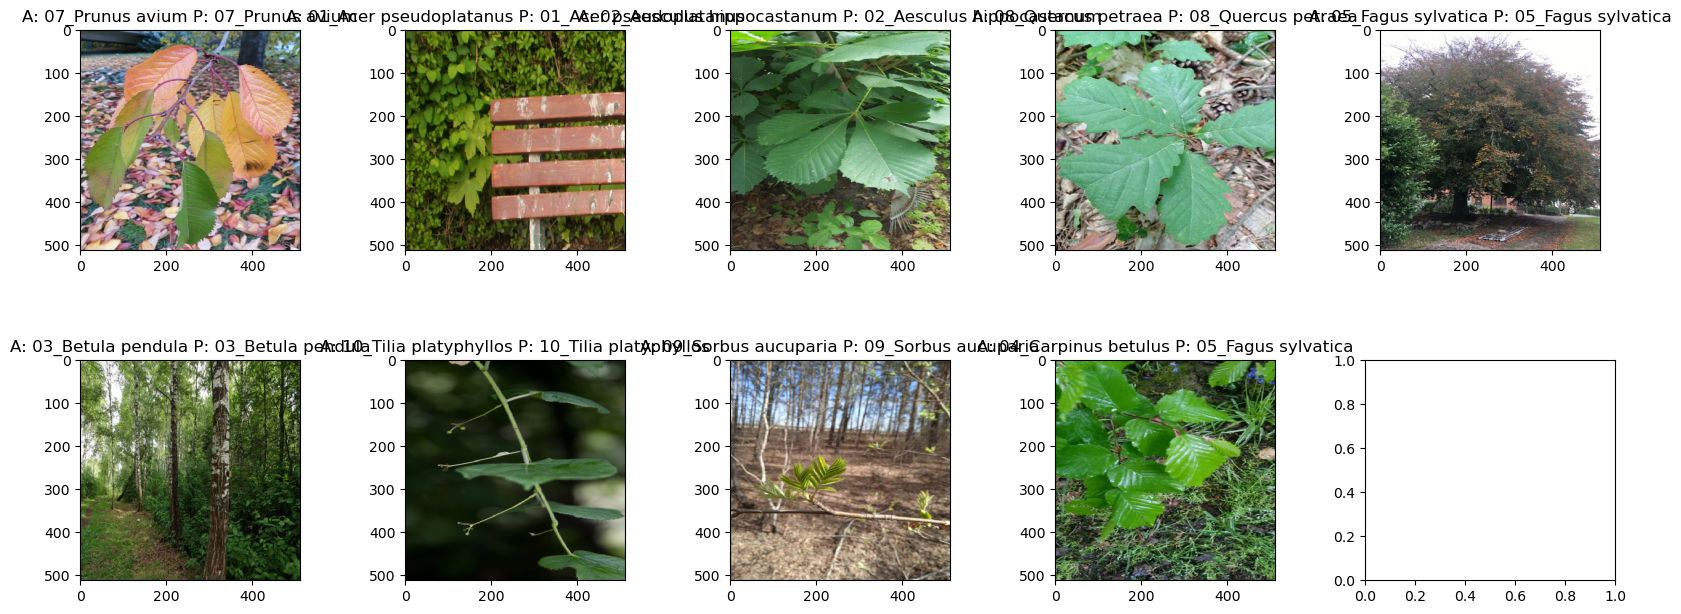

In [17]:
#correct the below code
display_images(val_df[1:10])
#display_images(val_df[1:10])

### Misclassified

KeyError: 1

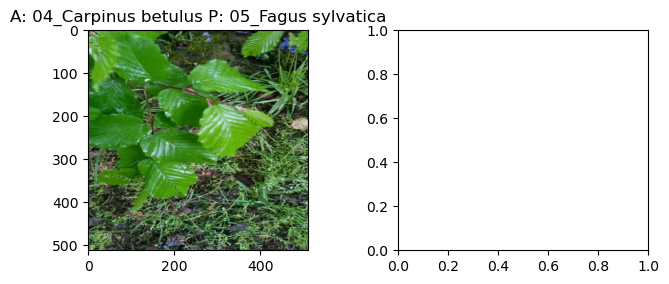

In [18]:
display_images(val_df[val_df['Same']!=True])

### Grad-CAM Computation
- Gradient computed of the final softmax layer with respect to the last convolution layer
- The fourth last layer of our model is the final convolutional block in our VGG-16 finetuned architecture
- Mean of the gradients is then multiplied to the last convolution layer's output 
- The output is then passed through a relu function to ensure that all values are positive

In [19]:
def make_gradcam_heatmap(img_array, model, pred_index=None):
    
    grad_model = Model(inputs=model.inputs, outputs=[model.layers[-4].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

In [20]:
import matplotlib.cm as cm

In [21]:
val_df

,filename,actual,predicted,Same
0,06_Fraxinus excelsior/Fraxinus excelsior000000...,06_Fraxinus excelsior,06_Fraxinus excelsior,True
1,07_Prunus avium/Prunus avium0000001.jpg,07_Prunus avium,07_Prunus avium,True
2,01_Acer pseudoplatanus/Acer pseudoplatanus0000...,01_Acer pseudoplatanus,01_Acer pseudoplatanus,True
3,02_Aesculus hippocastanum/Aesculus hippocastan...,02_Aesculus hippocastanum,02_Aesculus hippocastanum,True
4,08_Quercus petraea/Quercus petraea0000001.jpg,08_Quercus petraea,08_Quercus petraea,True
5,05_Fagus sylvatica/Fagus sylvatica0000001.jpg,05_Fagus sylvatica,05_Fagus sylvatica,True
6,03_Betula pendula/Betula pendula0000001.jpg,03_Betula pendula,03_Betula pendula,True
7,10_Tilia platyphyllos/Tilia platyphyllos000000...,10_Tilia platyphyllos,10_Tilia platyphyllos,True
8,09_Sorbus aucuparia/Sorbus aucuparia0000001.jpg,09_Sorbus aucuparia,09_Sorbus aucuparia,True
9,04_Carpinus betulus/Carpinus betulus0000001.jpg,04_Carpinus betulus,05_Fagus sylvatica,False


### Grad-CAM Projection
- The heatmap produced using the Grad-CAM computation is then projected on to the original image
- The heatmap highlights the important parts of the image that lead to the activation of a class in the final softmax layer

In [22]:
def gradCAMImage(image):
    path = f"{data_path}{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img,model)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    
    return superimposed_img

## Results

In [23]:
def gradcam_of_images(correct_class):
    grad_images = []
    title = []
    temp_df = val_df[1:10]
    temp_df = temp_df.reset_index(drop=True)
    for i in range(15):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        title.append(f"A: {temp_df.actual[i]} P: {temp_df.predicted[i]}")

    return grad_images, title

In [24]:
correctly_classified, c_titles = gradcam_of_images(correct_class=True)
misclassified, m_titles = gradcam_of_images(correct_class=False)

ResourceExhaustedError: Exception encountered when calling layer "block2g_expand_activation" "                 f"(type Activation).

{{function_node __wrapped__Sigmoid_device_/job:localhost/replica:0/task:0/device:GPU:0}} failed to allocate memory [Op:Sigmoid]

Call arguments received by layer "block2g_expand_activation" "                 f"(type Activation):
  • inputs=tf.Tensor(shape=(1, 128, 128, 288), dtype=float32)

In [87]:
def display_heatmaps(classified_images,titles):
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i])
    plt.show()

### Grad-CAM: Correctly Classified

In [88]:
display_heatmaps(correctly_classified,c_titles)

NameError: name 'correctly_classified' is not defined

**Inference:** As it can be seen some important features of the animals are highlighted in the image
- Mouth of a dog
- Fluffy woolen body of a sheep
- Legs and body of a spider
- Mouth of a squirrel
- Head of a horse
- etc.

### Grad-CAM: Incorrectly Classified

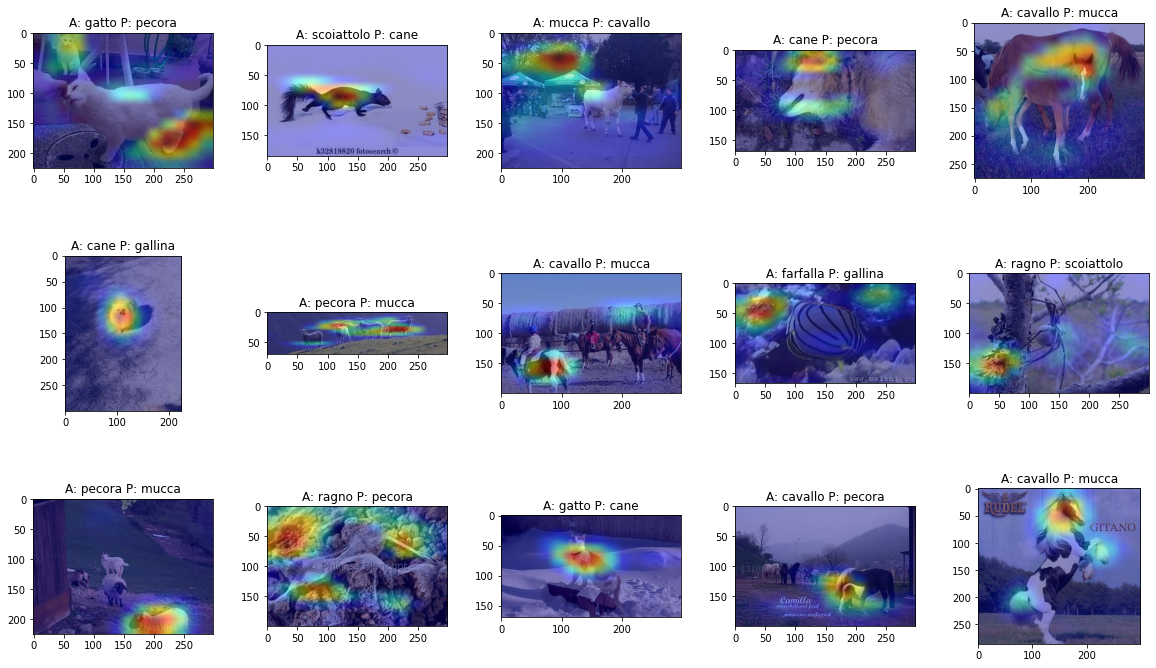

In [27]:
display_heatmaps(misclassified,m_titles)

**Inference:** As it can be seen some features have been incorrectly detected on some of these animal pictures either due to the positioning of the animal in the image or due to the orientation of the image
e.g.
- Distant image of a Pomerian breed dog is misinterpretted as chicken due to its small size
- Furry cat in the distance is misinterpretted as a sheep
- Body of animals like sheep and horse are being misinterpretted as cow due to the sideways orientation of the animal in the image
- A close up sideways picture of a furry dog is misinterpretted as sheep
- etc.

These challenges can be resolved by changing the setting of augmentation techniques used in the model pipeline

## Conclusion

The aim of this notebook was to demonstrate the Grad-CAM method and how it can be used to interpret the CNNs. Inferences from the the Grad-CAM visualizations can be used to further improve the model misclassifications and boost model performance